<a href="https://colab.research.google.com/github/aaditya9803/ml/blob/main/Condition%20monitoring%20of%20hydraulic%20systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Importing files from Google drive



In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# List of file names.
file_names = ['CE.txt', 'CP.txt', 'EPS1.txt', 'FS1.txt', 'FS2.txt',
              'PS1.txt', 'PS2.txt', 'PS3.txt', 'PS4.txt', 'PS5.txt',
              'PS6.txt', 'SE.txt', 'TS1.txt', 'TS2.txt', 'TS3.txt',
              'TS4.txt', 'VS1.txt','profile.txt']

# Get the ID of the current folder (where the notebook is located).
# Assuming the notebook is in "My Drive/Colab Notebooks" or similar
# by default.
# Alternatively, you can get a specific folder ID or use a method to find your folder
current_folder_id = '1KSKmvJYgR1N_0dOffHON1SFAlrlfwpMs' # Replace with your specific folder ID if needed


# Iterate through the file names and download each file.
for file_name in file_names:
    # List files in the current folder.
    file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(current_folder_id)}).GetList()

    # Find the file with the matching name.
    file_to_download = next((file for file in file_list if file['title'] == file_name), None)

    if file_to_download:
        # Download the file.
        print(f"Downloading {file_name}...")
        file_to_download.GetContentFile(file_name)  # Downloads to Colab environment
    else:
        print(f"File {file_name} not found in the folder.")

print("All files downloaded (if found).")

All files downloaded (if found).


# Importing python libraries

In [53]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import xgboost as xgb
import os
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

## Features and Targets

In [3]:
def read_file(filename):
    return pd.read_csv((filename), sep='\t', header=None)

pressureFile1 = read_file(filename='PS1.txt')
pressureFile2 = read_file(filename='PS2.txt')
pressureFile3 = read_file(filename='PS3.txt')
pressureFile4 = read_file(filename='PS4.txt')
pressureFile5 = read_file(filename='PS5.txt')
pressureFile6 = read_file(filename='PS6.txt')


volumeFlow1 = read_file(filename='FS1.txt')
volumeFlow2 = read_file(filename='FS2.txt')


temperature1 = read_file(filenamnvenie='TS1.txt')
temperature2 = read_file(filename='TS2.txt')
temperature3 = read_file(filename='TS3.txt')
temperature4 = read_file(filename='TS4.txt')

pump1 = read_file(filename='EPS1.txt')
vibration1 = read_file(filename='VS1.txt')
coolingE1 = read_file(filename='CE.txt')
coolingP1 = read_file(filename='CP.txt')
effFactor1 = read_file(filename='SE.txt')

profile = read_file(filename='profile.txt')


# for the targets

y_coolerCondition = pd.DataFrame(profile.iloc[:, 0])
y_valveCondition = pd.DataFrame(profile.iloc[:, 1])
y_pumpLeak = pd.DataFrame(profile.iloc[:, 2])
y_hydraulicAcc = pd.DataFrame(profile.iloc[:, 3])
y_stableFlag = pd.DataFrame(profile.iloc[:, 4])


In [4]:
pressureFile1.shape


(2205, 6000)

##Functions to Upsample and Downsample

In [5]:
#converts 100hz to 10hz
def mean_conversion_100hz(df, chunk_size=10, prefix=''):
    num_chunks = df.shape[1] // chunk_size
    columns = [f'{prefix}_{i}' for i in range(num_chunks)]
    df_mean_chunks = pd.DataFrame(index=df.index, columns=columns)

    for index, row in df.iterrows():
        mean_chunks = row.values.reshape(-1, chunk_size).mean(axis=1)
        df_mean_chunks.loc[index] = mean_chunks

    return df_mean_chunks


#converts 100hz to 1z
def mean_conversion_1hz(df, chunk_size=100, prefix=''):
    num_chunks = df.shape[1] // chunk_size
    columns = [f'{prefix}_{i}' for i in range(num_chunks)]
    df_mean_chunks = pd.DataFrame(index=df.index, columns=columns)

    for index, row in df.iterrows():
        mean_chunks = row.values.reshape(-1, chunk_size).mean(axis=1)
        df_mean_chunks.loc[index] = mean_chunks

    return df_mean_chunks

#For Upsampling
def repeat_values(df, repeat_count=10):
    all_expanded_rows = []

    for index, row in df.iterrows():
        expanded_row = np.repeat(row.values, repeat_count)
        all_expanded_rows.append(pd.Series(expanded_row))
    df_expanded = pd.concat(all_expanded_rows, ignore_index=True)  # Concatenate all rows at once

    return df_expanded

#For mean of the row (mean of the cycle)
def mean_conversion(df):
    df1 = pd.DataFrame()
    df1['mean'] = df.mean(axis=1)
    return df1

## Upsampling and Downsampling to 10hz

In [6]:
# #100HZ TO 10HZ
# PS1 = mean_conversion_100hz(pressureFile1)
# PS1.columns = [f'PS1_{i}' for i in range(PS1.shape[1])]

# PS2 = mean_conversion_100hz(pressureFile2)
# PS2.columns = [f'PS2_{i}' for i in range(PS2.shape[1])]

# PS3 = mean_conversion_100hz(pressureFile3)
# PS3.columns = [f'PS3_{i}' for i in range(PS3.shape[1])]

# PS4 = mean_conversion_100hz(pressureFile4)
# PS4.columns = [f'PS4_{i}' for i in range(PS4.shape[1])]

# PS5 = mean_conversion_100hz(pressureFile5)
# PS5.columns = [f'PS5_{i}' for i in range(PS5.shape[1])]

# PS6 = mean_conversion_100hz(pressureFile6)
# PS6.columns = [f'PS6_{i}' for i in range(PS6.shape[1])]

# P1 = mean_conversion_100hz(pump1)
# P1.columns = [f'P1_{i}' for i in range(P1.shape[1])]

# #Leaving 10HZ as it is

# FS1 = pd.DataFrame(volumeFlow1)
# FS1.columns = [f'FS1_{i}' for i in range(FS1.shape[1])]

# FS2 = pd.DataFrame(volumeFlow2)
# FS2.columns = [f'FS2_{i}' for i in range(FS2.shape[1])]

# #1HZ to 10HZ

# TS1 = pd.DataFrame(repeat_values(temperature1))
# TS1.columns = ['TS1']

# TS2 = pd.DataFrame(repeat_values(temperature2))
# TS2.columns = ['TS2']

# TS3 = pd.DataFrame(repeat_values(temperature3))
# TS3.columns = ['TS3']

# TS4 = pd.DataFrame(repeat_values(temperature4))
# TS4.columns = ['TS4']

# VS1 = pd.DataFrame(repeat_values(vibration1))
# VS1.columns = ['VS1']

# CE1 = pd.DataFrame(repeat_values(coolingE1))
# CE1.columns = ['CE1']

# CP1 = pd.DataFrame(repeat_values(coolingP1))
# CP1.columns = ['CP1']

# SE1 = pd.DataFrame(repeat_values(effFactor1))
# SE1.columns = ['SE1']

## DownSampling to 1HZ

In [7]:
#100HZ TO 1HZ
PS1 = mean_conversion_1hz(pressureFile1)
PS1.columns = [f'PS1_{i}' for i in range(PS1.shape[1])]

PS2 = mean_conversion_1hz(pressureFile2)
PS2.columns = [f'PS2_{i}' for i in range(PS2.shape[1])]

PS3 = mean_conversion_1hz(pressureFile3)
PS3.columns = [f'PS3_{i}' for i in range(PS3.shape[1])]

PS4 = mean_conversion_1hz(pressureFile4)
PS4.columns = [f'PS4_{i}' for i in range(PS4.shape[1])]

PS5 = mean_conversion_1hz(pressureFile5)
PS5.columns = [f'PS5_{i}' for i in range(PS5.shape[1])]

PS6 = mean_conversion_1hz(pressureFile6)
PS6.columns = [f'PS6_{i}' for i in range(PS6.shape[1])]

P1 = mean_conversion_1hz(pump1)
P1.columns = [f'P1_{i}' for i in range(P1.shape[1])]

#10hz to 1hz

FS1 = pd.DataFrame(mean_conversion_100hz(volumeFlow1))
FS1.columns = [f'FS1_{i}' for i in range(FS1.shape[1])]

FS2 = pd.DataFrame(mean_conversion_100hz(volumeFlow2))
FS2.columns = [f'FS2_{i}' for i in range(FS2.shape[1])]

#Leaving 1HZ as it is

TS1 = pd.DataFrame(temperature1)
TS1.columns = [f'TS1_{i}' for i in range(TS1.shape[1])]

TS2 = pd.DataFrame(temperature2)
TS2.columns = [f'TS2_{i}' for i in range(TS2.shape[1])]

TS3 = pd.DataFrame(temperature3)
TS3.columns = [f'TS3_{i}' for i in range(TS3.shape[1])]

TS4 = pd.DataFrame(temperature4)
TS4.columns = [f'TS4_{i}' for i in range(TS4.shape[1])]

VS1 = pd.DataFrame(vibration1)
VS1.columns = [f'VS1_{i}' for i in range(VS1.shape[1])]

CE1 = pd.DataFrame(coolingE1)
CE1.columns = [f'CE1_{i}' for i in range(CE1.shape[1])]

CP1 = pd.DataFrame(coolingP1)
CP1.columns = [f'CP1_{i}' for i in range(CP1.shape[1])]

SE1 = pd.DataFrame(effFactor1)
SE1.columns = [f'SE1_{i}' for i in range(SE1.shape[1])]

## Mean of a cycle (of the whole row)

In [8]:
# PS1 = pd.DataFrame(mean_conversion(pressureFile1))
# PS1.columns = ['PS1'] # Rename the column to 'PS1'

# PS2 = pd.DataFrame(mean_conversion(pressureFile2))
# PS2.columns = ['PS2']

# PS3 = pd.DataFrame(mean_conversion(pressureFile3))
# PS3.columns = ['PS3']

# PS4 = pd.DataFrame(mean_conversion(pressureFile4))
# PS4.columns = ['PS4']

# PS5 = pd.DataFrame(mean_conversion(pressureFile5))
# PS5.columns = ['PS5']

# PS6 = pd.DataFrame(mean_conversion(pressureFile6))
# PS6.columns = ['PS6']

# FS1 = pd.DataFrame(mean_conversion(volumeFlow1))
# FS1.columns = ['FS1']

# FS2 = pd.DataFrame(mean_conversion(volumeFlow2))
# FS2.columns = ['FS2']

# TS1 = pd.DataFrame(mean_conversion(temperature1))
# TS1.columns = ['TS1']

# TS2 = pd.DataFrame(mean_conversion(temperature2))
# TS2.columns = ['TS2']

# TS3 = pd.DataFrame(mean_conversion(temperature3))
# TS3.columns = ['TS3']

# TS4 = pd.DataFrame(mean_conversion(temperature4))
# TS4.columns = ['TS4']

# P1 = pd.DataFrame(mean_conversion(pump1))
# P1.columns = ['P1']

# VS1 = pd.DataFrame(mean_conversion(vibration1))
# VS1.columns = ['VS1']

# CE1 = pd.DataFrame(mean_conversion(coolingE1))
# CE1.columns = ['CE1']

# CP1 = pd.DataFrame(mean_conversion(coolingP1))
# CP1.columns = ['CP1']

# SE1 = pd.DataFrame(mean_conversion(effFactor1))
# SE1.columns = ['SE1']

In [9]:
PS1.shape

(2205, 60)

In [10]:
X = pd.concat([PS1, PS2, PS3, PS4, PS5, PS6, FS1, FS2, TS1, TS2, TS3, TS4, P1, VS1, CE1, CP1, SE1], axis=1)
#X1.hist(bins=50, figsize=(20, 15))

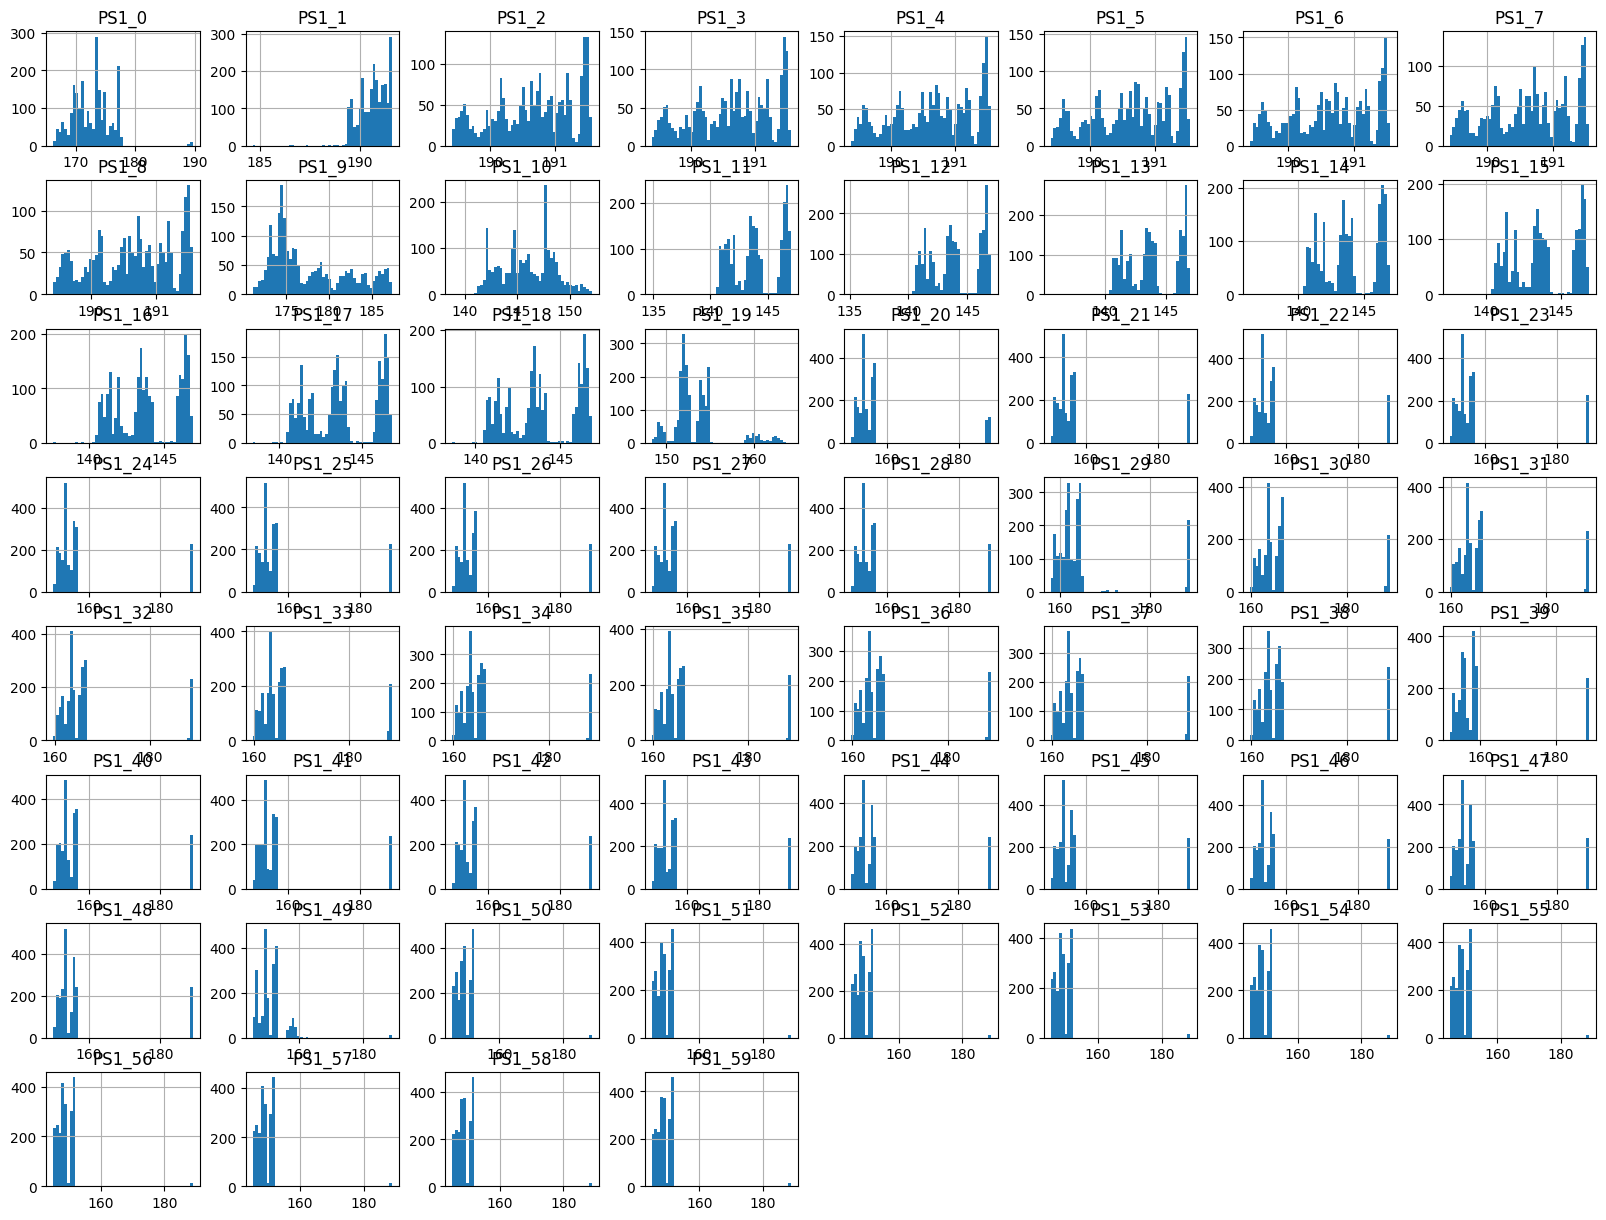

In [11]:
# Convert applicable columns to numeric type before plotting.
for col in PS1.columns:  # Changed PS3 to PS1
    try:
        # Attempt to convert the column to numeric.
        PS1[col] = pd.to_numeric(PS1[col])  # Changed PS3 to PS1
    except ValueError:
        # If conversion fails (e.g., due to non-numeric values),
        # print a message and continue.
        print(f"Could not convert column {col} to numeric. It might contain non-numeric values.")

# Now you can try plotting the histogram again.
PS1.hist(bins=50, figsize=(20, 15))
plt.show()

## Using XGB

In [12]:
def predict_pump_performance(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=24)

    num_classes = len(np.unique(y_train))

    if num_classes < 2:
        raise ValueError("Target variable must have at least 2 unique values for multi-class classification.")

    seed= 24

    if num_classes == 2 and len(y.shape) == 1:
        objective_func = 'binary:logistic'
    else:
        objective_func = 'multi:softprob'

    xgb1 = xgb.sklearn.XGBClassifier(
            learning_rate =0.1,
             n_estimators=100,
             max_depth=5,
             min_child_weight=11,
             gamma=0.1,
             subsample=0.8,
             colsample_bytree=0.7,
             objective=objective_func,
             n_jobs=-1,
             scale_pos_weight=1,
             seed=seed,
             num_class=num_classes
    )

    xgb1.fit(X_train, y_train)

    if objective_func == 'multi:softprob':
        y_pred_probs = xgb1.predict_proba(X_val)
        y_pred = np.argmax(y_pred_probs, axis=1)
    else:
        y_pred = xgb1.predict(X_val)

    y_val = y_val.astype(int)
    y_pred = y_pred.astype(int)

    #confusion matrix and classification report

    cm = confusion_matrix(y_val, y_pred)

    print(classification_report(y_val, y_pred))

In [13]:
for col in X.select_dtypes(include=['object']).columns:
    try:
        X[col] = pd.to_numeric(X[col])
    except ValueError:
        print(f"Could not convert column {col} to numeric. It might contain non-numeric values.")

In [44]:
predict_pump_performance(X, y_stableFlag)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:03:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.95      0.98      0.97        58
           1       0.97      0.90      0.93        31

    accuracy                           0.96        89
   macro avg       0.96      0.94      0.95        89
weighted avg       0.96      0.96      0.95        89



## Using Linear Regression

In [45]:
def predict_pump_performance_linear(X, y, num_folds=5):
    kf = KFold(n_splits=num_folds, shuffle = True, random_state=24)
    mse_scores = []
    r2_scores = []

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_scores.append(mse)
        r2_scores.append(r2)

        print(f"Mean Squared Error: {np.mean(mse_scores):.4f}")
        print(f"R-squared: {r2}")

In [46]:
predict_pump_performance_linear(X, y_stableFlag)

Mean Squared Error: 0.0931
R-squared: 0.5541383527835676
Mean Squared Error: 0.0975
R-squared: 0.5634644874213119
Mean Squared Error: 0.0914
R-squared: 0.6571962744874664
Mean Squared Error: 0.1090
R-squared: 0.3055421444858971
Mean Squared Error: 0.1034
R-squared: 0.6246756146032382


## Using SVM

In [54]:
def svm(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
    random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Create the SVM model
    model = SVC(kernel='rbf',
    C=1, gamma='auto')

    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation

    # Print cross-validation scores
    print("Cross-validation scores:", scores)
    print("Average cross-validation score:", scores.mean())


    # Train the model on the entire training set
    model.fit(X_train, y_train)

    # Make predictions on the test set and evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test set accuracy: {accuracy}")

In [55]:
svm(X,y_stableFlag)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Cross-validation scores: [0.90614887 0.90614887 0.92556634 0.92857143 0.93181818]
Average cross-validation score: 0.9196507376119026


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test set accuracy: 0.9244712990936556


## Using Random forest

In [34]:
def randomforest(X, y, num_folds=5):
    kf = KFold(n_splits=num_folds, shuffle = True, random_state=24)
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):

            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
            rf_model.fit(X_train, y_train)
            y_pred = rf_model.predict(X_test)
            print(classification_report(y_test, y_pred))
            print(f"Fold {fold_idx + 1}")

In [35]:
randomforest(X,y_stableFlag)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98       310
           1       1.00      0.92      0.96       131

    accuracy                           0.98       441
   macro avg       0.98      0.96      0.97       441
weighted avg       0.98      0.98      0.97       441

Fold 1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       277
           1       1.00      0.93      0.96       164

    accuracy                           0.97       441
   macro avg       0.98      0.96      0.97       441
weighted avg       0.97      0.97      0.97       441

Fold 2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       281
           1       1.00      0.97      0.98       160

    accuracy                           0.99       441
   macro avg       0.99      0.98      0.99       441
weighted avg       0.99      0.99      0.99       441

Fold 3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.97      1.00      0.99       278
           1       1.00      0.95      0.97       163

    accuracy                           0.98       441
   macro avg       0.99      0.98      0.98       441
weighted avg       0.98      0.98      0.98       441

Fold 4


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       303
           1       1.00      0.91      0.95       138

    accuracy                           0.97       441
   macro avg       0.98      0.96      0.97       441
weighted avg       0.97      0.97      0.97       441

Fold 5


## Using Neural Networks

In [41]:
def neuralnetwork(X, y, num_folds=10, patience=3):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=24)
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Build the model
        model = keras.Sequential([
            keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # EarlyStopping callback
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=Truetask2
        )

        # Fit the model with early stopping callback
        model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping]
        )

        # Evaluate the model on the test set after training
        test_loss, test_accuracy = model.evaluate(X_test, y_test)
        print(f"Fold {fold_idx + 1}: Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.4f}")

In [42]:
neuralnetwork(X,y_stableFlag)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8115 - loss: 0.4351 - val_accuracy: 0.5315 - val_loss: 1.5307
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9394 - loss: 0.1703 - val_accuracy: 0.8766 - val_loss: 0.5492
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9410 - loss: 0.1607 - val_accuracy: 0.7380 - val_loss: 0.9591
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9580 - loss: 0.1272 - val_accuracy: 0.7456 - val_loss: 0.9108
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9486 - loss: 0.1371 - val_accuracy: 0.8186 - val_loss: 0.5124
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9529 - loss: 0.1304 - val_accuracy: 0.7582 - val_loss: 1.0561
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9608 - loss: 0.1062 - val_accuracy: 0.8338 - val_loss: 0.5026
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9686 - loss: 0.0940 - val_accuracy: 0.7481 - val_loss: 1.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7463 - loss: 0.4908 - val_accuracy: 0.6877 - val_loss: 0.6272
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9370 - loss: 0.1715 - val_accuracy: 0.7884 - val_loss: 0.4841
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9440 - loss: 0.1385 - val_accuracy: 0.6801 - val_loss: 1.0052
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9568 - loss: 0.1175 - val_accuracy: 0.8312 - val_loss: 0.3768
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9515 - loss: 0.1346 - val_accuracy: 0.8841 - val_loss: 0.3349
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9604 - loss: 0.1138 - val_accuracy: 0.7506 - val_loss: 0.6868
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9454 - loss: 0.1298 - val_accuracy: 0.6700 - val_loss: 1.4893
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9569 - loss: 0.1117 - val_accuracy: 0.7078 - val_loss: 1.1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7987 - loss: 0.4638 - val_accuracy: 0.6096 - val_loss: 1.1397
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9365 - loss: 0.1622 - val_accuracy: 0.6121 - val_loss: 1.1043
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9399 - loss: 0.1542 - val_accuracy: 0.7053 - val_loss: 0.6409
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9585 - loss: 0.1217 - val_accuracy: 0.5894 - val_loss: 1.8062
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9527 - loss: 0.1148 - val_accuracy: 0.7003 - val_loss: 0.8948
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9650 - loss: 0.0928 - val_accuracy: 0.6045 - val_loss: 1.8009
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9316 - loss: 0.1481 
Fold 3: Test Loss = 0.2207, Test Accuracy = 0.9005
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8007 - loss: 0.4624 - val_accuracy: 0.6877 - val_loss: 0.7478
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9430 - loss: 0.1908 - val_accuracy: 0.7179 - val_loss: 0.7932
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9347 - loss: 0.1488 - val_accuracy: 0.7834 - val_loss: 0.5134
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9609 - loss: 0.1123 - val_accuracy: 0.7607 - val_loss: 0.6623
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9531 - loss: 0.1355 - val_accuracy: 0.7380 - val_loss: 0.8821
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9642 - loss: 0.0931 - val_accuracy: 0.7380 - val_loss: 0.9111
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9134 - loss: 0.1843 
Fold 4: Test Loss = 0.1964, Test Accuracy = 0.9050
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7789 - loss: 0.4528 - val_accuracy: 0.7305 - val_loss: 0.5878
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9252 - loss: 0.2291 - val_accuracy: 0.6297 - val_loss: 1.3532
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9368 - loss: 0.1918 - val_accuracy: 0.8212 - val_loss: 0.4159
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9565 - loss: 0.1255 - val_accuracy: 0.8489 - val_loss: 0.3843
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9480 - loss: 0.1359 - val_accuracy: 0.7683 - val_loss: 0.6489
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9484 - loss: 0.1476 - val_accuracy: 0.8539 - val_loss: 0.3879
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9564 - loss: 0.1189 - val_accuracy: 0.7557 - val_loss: 0.9516
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9561 - loss: 0.0962 
Fold 5: Test Loss = 0.1780, Test Accuracy = 0.9321


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7605 - loss: 0.4745 - val_accuracy: 0.6297 - val_loss: 0.9556
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9313 - loss: 0.1783 - val_accuracy: 0.8741 - val_loss: 0.4171
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9438 - loss: 0.1340 - val_accuracy: 0.6952 - val_loss: 0.9249
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9547 - loss: 0.1240 - val_accuracy: 0.8035 - val_loss: 0.4296
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9462 - loss: 0.1316 - val_accuracy: 0.6977 - val_loss: 1.0299
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9504 - loss: 0.1835 
Fold 6: Test Loss = 0.1618, Test Accuracy = 0.9409
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7872 - loss: 0.4503 - val_accuracy: 0.8640 - val_loss: 0.4109
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9433 - loss: 0.1772 - val_accuracy: 0.6247 - val_loss: 0.9348
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9499 - loss: 0.1446 - val_accuracy: 0.7809 - val_loss: 0.4745
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9548 - loss: 0.1271 - val_accuracy: 0.8841 - val_loss: 0.3492
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9467 - loss: 0.1430 - val_accuracy: 0.8741 - val_loss: 0.3934
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9644 - loss: 0.0980 - val_accuracy: 0.6725 - val_loss: 1.3405
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9634 - loss: 0.0976 - val_accuracy: 0.7128 - val_loss: 0.9362
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9605 - loss: 0.1382 
Fold 7: Test Loss = 0.2093, Test Accuracy = 0.9364

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8067 - loss: 0.4314 - val_accuracy: 0.7003 - val_loss: 0.6900
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9275 - loss: 0.1855 - val_accuracy: 0.8086 - val_loss: 0.4490
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9408 - loss: 0.1574 - val_accuracy: 0.8866 - val_loss: 0.4055
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9481 - loss: 0.1355 - val_accuracy: 0.7733 - val_loss: 0.7027
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9511 - loss: 0.1482 - val_accuracy: 0.6927 - val_loss: 1.2899
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9606 - loss: 0.1084 - val_accuracy: 0.8690 - val_loss: 0.3490
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9537 - loss: 0.1069 - val_accuracy: 0.7128 - val_loss: 1.3735
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9679 - loss: 0.1013 - val_accuracy: 0.7531 - val_loss: 1.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8131 - loss: 0.4054 - val_accuracy: 0.8212 - val_loss: 0.3856
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9310 - loss: 0.1890 - val_accuracy: 0.8892 - val_loss: 0.4008
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9423 - loss: 0.1641 - val_accuracy: 0.7884 - val_loss: 0.5155
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9538 - loss: 0.1281 - val_accuracy: 0.7557 - val_loss: 0.7204
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9222 - loss: 0.2220 
Fold 9: Test Loss = 0.2463, Test Accuracy = 0.9045
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8194 - loss: 0.4163 - val_accuracy: 0.6071 - val_loss: 1.2838
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9414 - loss: 0.1686 - val_accuracy: 0.7909 - val_loss: 0.4540
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9491 - loss: 0.1390 - val_accuracy: 0.5592 - val_loss: 1.8949
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9467 - loss: 0.1326 - val_accuracy: 0.8363 - val_loss: 0.3263
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9197 - loss: 0.1992 - val_accuracy: 0.7154 - val_loss: 0.9872
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9546 - loss: 0.1193 - val_accuracy: 0.6776 - val_loss: 1.8720
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9609 - loss: 0.1033 - val_accuracy: 0.4962 - val_loss: 2.6245
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9316 - loss: 0.1941 
Fold 10: Test Loss = 0.2653, Test Accuracy = 0.900